In [14]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk', font_scale=1.4)
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc
from pyDOE import *
import os
from scipy.stats import norm
import math

In [2]:
class Ex4Func(object):
    def __init__(self, sigma=lambda x: 0.5):
        self.sigma = sigma

    def __call__(self, x):
        """
        Taken from Knowles et al. ref 16 of the paper.
        """
        y = 10 * math.sin(np.pi * x[0] * x[1]) + (20 * ((x[2] - 5) ** 2)) + 10 * x[3] + 5 * x[4] 
        return (y - 400) / 50.

In [3]:
dim = 5
n = 8
noise=0
sigma = eval('lambda x: ' + str(noise))

objective = Ex4Func(sigma=sigma)
X = lhs(dim, n , criterion='center')
Xnorm = (X - 0.5) /0.5
Y = np.array([objective(x) for x in X])[:, None]

In [4]:
kerns_list = [gpflow.kernels.RBF(1), gpflow.kernels.RBF(1), gpflow.kernels.RBF(1),
             gpflow.kernels.RBF(1), gpflow.kernels.RBF(1)]
mean_funcs_list = [gpflow.mean_functions.Constant(0), gpflow.mean_functions.Constant(0),
                  gpflow.mean_functions.Constant(0), gpflow.mean_functions.Constant(0),
                  gpflow.mean_functions.Constant(0)]
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()

In [5]:
m = hetero_gpmc.GPMCAdaptiveLengthscaleMultDimDev(Xnorm, Y, kerns_list, nonstat, mean_funcs_list)

In [6]:
for i in xrange(dim):
    m.kerns_list[i].lengthscales.prior = gpflow.priors.Gamma(1., 1.)
    m.kerns_list[i].variance.prior = gpflow.priors.Gamma(1., 1.)
    m.mean_funcs_list[i].c = 0.
    m.mean_funcs_list[i].c.fixed = True
    
m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance = 1e-6
m.likelihood.variance.fixed = True

In [7]:
#m.mean_funcs_list[0].c = 0.
#m.mean_funcs_list[0].c.fixed = True 
#m.mean_funcs_list[1].c = 0.
#m.mean_funcs_list[1].c.fixed = True 
#m.mean_funcs_list[2].c = 0.
#m.mean_funcs_list[2].c.fixed = True 

m.optimize(maxiter=5000) # start near MAP

In [9]:
samples = m.sample(500, verbose=True, epsilon=0.00005, thin = 2, burn = 500, Lmax = 20)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  100.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  100.0 %
Iteration:  600 	 Acc Rate:  100.0 %
Iteration:  700 	 Acc Rate:  100.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  100.0 %
Iteration:  1000 	 Acc Rate:  100.0 %


In [10]:
X_test = lhs(dim, 100 , criterion='center')
X_test_norm = (X_test - 0.5) /0.5
Y_test = np.array([objective(x) for x in X_test])[:, None]

# Model fit (training data)

## Visualizing predictions

1. Focussing on 1st dimension $x_{1}$
2. Focussing on 2nd dimension $x_{2}$
3. Focussing on 3rd dimension $x_{3}$
4. Focussing on 4rd dimension $x_{4}$
5. Focussing on 4rd dimension $x_{5}$

In [12]:
sample_df = m.get_samples_df(samples)
mean_f_mat_train = np.zeros(shape=(sample_df.shape[0], Xnorm.shape[0]))
var_f_mat_train = np.zeros(shape=(sample_df.shape[0], Xnorm.shape[0]))

for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean_f, var_f = m.predict(Xnorm)
    mean_f_mat_train[i, :] = mean_f[:,0]
    var_f_mat_train[i, :] = np.diag(var_f)

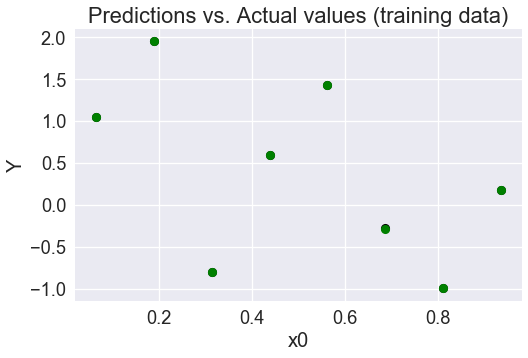

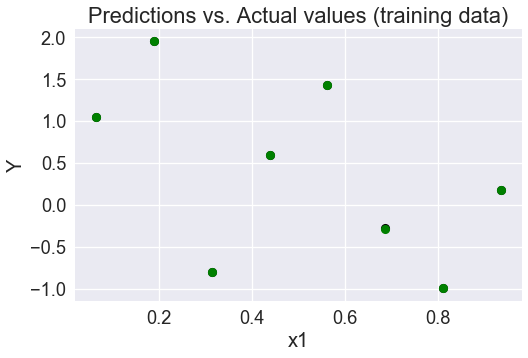

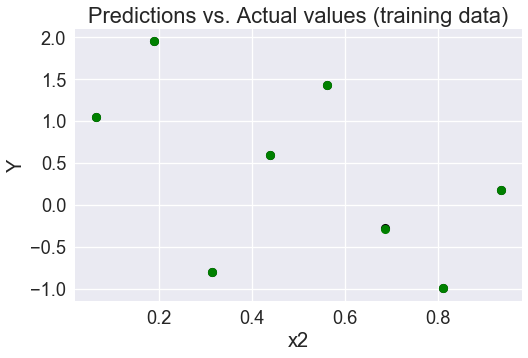

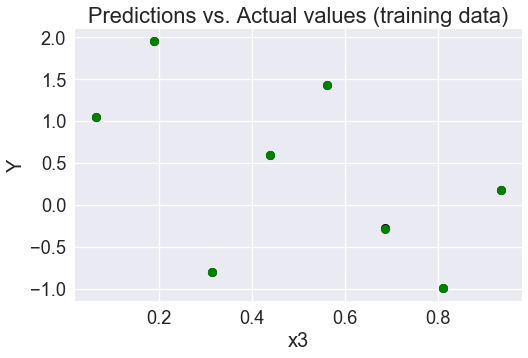

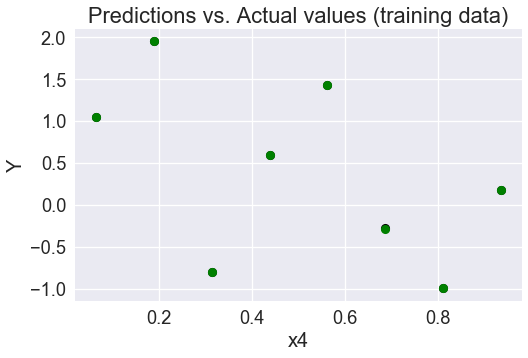

In [15]:
for i in xrange(X.shape[1]):
    plt.figure(figsize=(8,5))
    plt.plot(X[:,0], Y, 'ok')
    plt.plot(X[:,0], mean_f, 'og')
    plt.xlabel('x' + str(i))
    plt.ylabel('Y')
    plt.title('Predictions vs. Actual values (training data)')
    plt.savefig('plots/training_data_fit_dim' + str(i) + 'n' + str(n) + '.png')

# Predictions on random testing data

# Model's generalization capability on testing set

In [16]:
# Random 5 D test set
X_test = lhs(dim, 100 , criterion='center')
X_test_norm = (X_test - 0.5) /0.5
Y_test = np.array([objective(x) for x in X_test])[:, None]

In [17]:
mean_f_mat = np.zeros(shape=(sample_df.shape[0], X_test_norm.shape[0]))
var_f_mat = np.zeros(shape=(sample_df.shape[0], X_test_norm.shape[0]))

In [18]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean_f, var_f = m.predict(X_test_norm)
    mean_f_mat[i, :] = mean_f[:,0]
    var_f_mat[i, :] = np.diag(var_f)

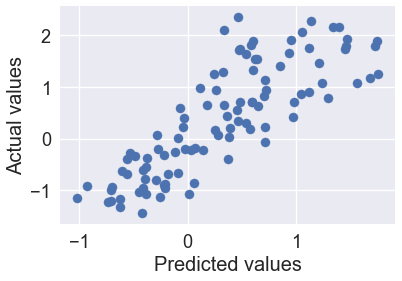

In [22]:
plt.scatter(mean_f_mat[2,:], Y_test)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.savefig('plots/actual_vs_pred' + 'n' + str(n) + '.png', dpi = 400)

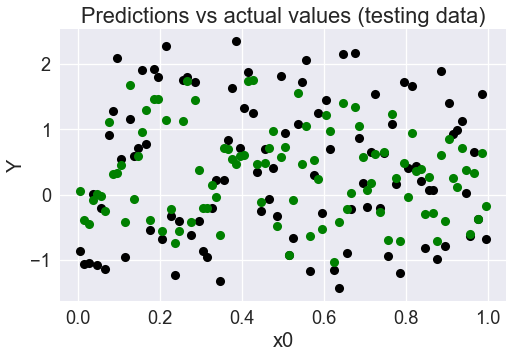

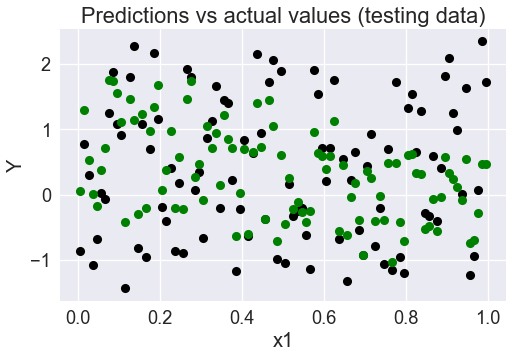

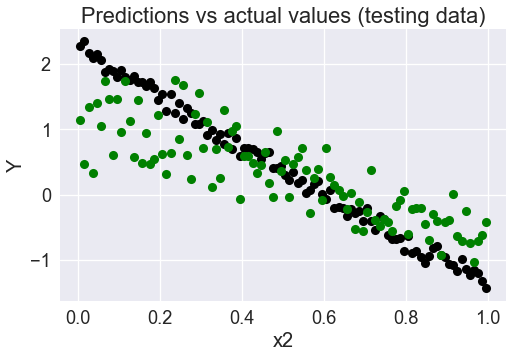

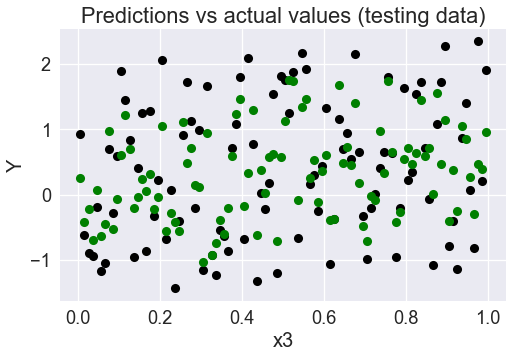

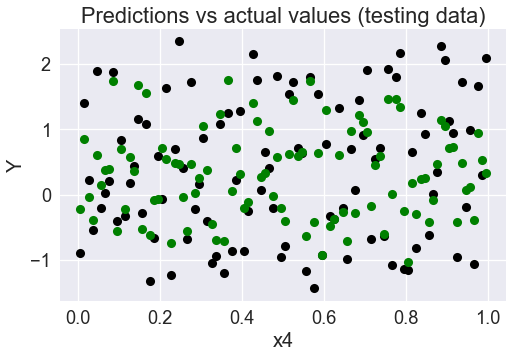

In [23]:
for i in xrange(X.shape[1]):
    plt.figure(figsize=(8,5))
    plt.plot(X_test[:,i], Y_test, 'ok', label = 'actual')
    plt.plot(X_test[:,i], mean_f_mat[0,:], 'og', label = 'predicted')
    plt.xlabel('x' + str(i))
    plt.ylabel('Y')
    plt.title('Predictions vs actual values (testing data)')
    plt.savefig('plots/actual_vs_pred_randomized_testing_dim' + str(i) + '.png', dpi = 400)
    #plt.legend(loc = 'best')

## Visualizing posterior predictive distributions

1. Focussing on 1st dimension $x_{1}$
2. Focussing on 2nd dimension $x_{2}$
3. Focussing on 3rd dimension $x_{3}$
4. Focussing on 4rd dimension $x_{4}$
5. Focussing on 4rd dimension $x_{5}$

In [25]:
x_vary = np.linspace(0,1, 50)
x_constant = np.repeat(0.5, x_vary.shape[0])

Xt1 = np.vstack([x_vary, x_constant, x_constant, x_constant, x_constant]).T
Xt2 = np.vstack([x_constant, x_vary, x_constant, x_constant, x_constant]).T
Xt3 = np.vstack([x_constant, x_constant, x_vary, x_constant, x_constant]).T
Xt4 = np.vstack([x_constant, x_constant, x_constant, x_vary, x_constant]).T
Xt5 = np.vstack([x_constant, x_constant, x_constant, x_constant, x_vary]).T

Y_test1 = np.array([objective(x) for x in Xt1])[:, None]
Y_test2 = np.array([objective(x) for x in Xt2])[:, None]
Y_test3 = np.array([objective(x) for x in Xt3])[:, None]
Y_test4 = np.array([objective(x) for x in Xt4])[:, None]
Y_test5 = np.array([objective(x) for x in Xt5])[:, None]

In [26]:
Xt = np.dstack([Xt1, Xt2, Xt3, Xt4, Xt5])
Xtnorm = (Xt - 0.5) /0.5
Yt = np.hstack([Y_test1, Y_test2, Y_test3, Y_test4, Y_test5])

In [27]:
mean_f_mat_test = np.zeros(shape=(sample_df.shape[0], Xtnorm.shape[0],Xtnorm.shape[2]))
var_f_mat_test = np.zeros(shape=(sample_df.shape[0], Xtnorm.shape[0], Xtnorm.shape[2]))

In [28]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    for j in xrange(Xtnorm.shape[2]):
        mean_f, var_f = m.predict(Xtnorm[:,:,j])
        mean_f_mat_test[i,:,j] = mean_f[:,0]
        var_f_mat_test[i,:,j] = np.diag(var_f)

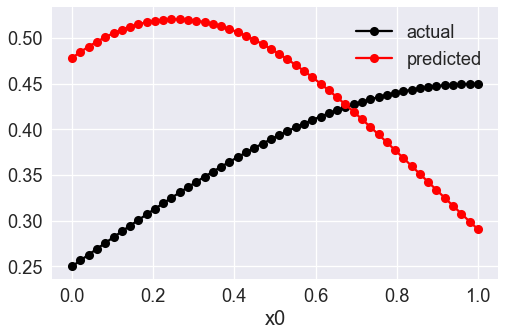

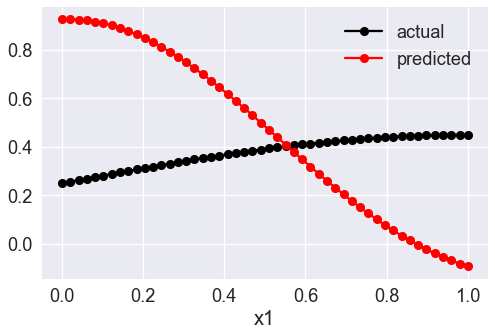

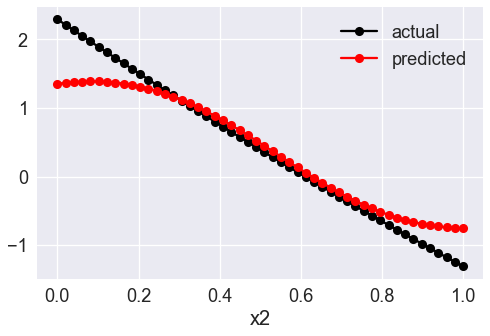

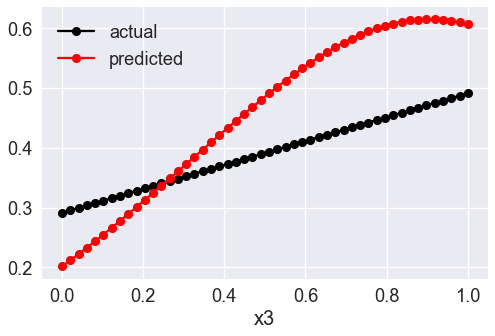

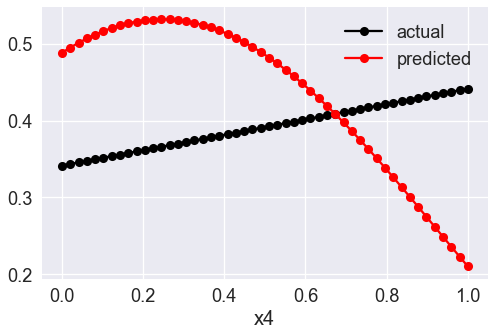

In [29]:
for i in xrange(Xtnorm.shape[1]):
    #print i
    plt.figure(figsize=(8,5))
    plt.plot(Xt[:,i,i], Yt[:,i], '-ok', label = 'actual')
    plt.plot(Xt[:,i,i], mean_f_mat_test[0,:,i], '-or', label = 'predicted')
    plt.legend(loc = 'best')
    plt.xlabel('x' + str(i))
    plt.savefig('plots/actual_vs_pred_seq_testing_dim' + str(i) + '.png', dpi = 400)